# Hospital Encounter Analysis by Alyssa 
Data provided by ELVTR course Data Analysis in Healthcare

## Data loading and preprocessing
Let's start with loading and checking for duplicates, and missing data. After loading, I will review the number of rows, columns, and data types.

In [1]:
#import pandas the data analysis library for python
import pandas as pd 

#upload excel file
encdf = pd.read_excel("hospital_encounter_data_10_24AC.xlsx")


print(encdf.head())

   encounter_id  admission_date origin  service_line      loc    drg  \
0  5AP7T95R6HG6           44927    ED   Internal Med  GEN MED  392.0   
1  UBE6BNHXJDV6           44927    ED   Internal Med  GEN MED  871.0   
2  2G6U4ZHPWW5V           44927    ED   Internal Med  GEN MED  871.0   
3  BSHAPPAB3YFC           44927    ED   Internal Med      PCU  871.0   
4  V6XH3DEFDTTT           44927    ED   Internal Med  GEN MED  871.0   

   discharge_date  patient_zipcode  
0           44939            65072  
1           44931            64742  
2           44929            66524  
3           44957            64150  
4           44930            64097  


In [2]:
encdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97436 entries, 0 to 97435
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   encounter_id     97436 non-null  object 
 1   admission_date   97436 non-null  int64  
 2   origin           97436 non-null  object 
 3   service_line     97436 non-null  object 
 4   loc              94512 non-null  object 
 5   drg              90616 non-null  float64
 6   discharge_date   97436 non-null  int64  
 7   patient_zipcode  97436 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 5.9+ MB


Yup that is what we expected. 
The range index indicates 97,436 entries and 8 columns (note: python index starts wih 0). Some of the data types are not quite right, I'll fix that later.

## Check for duplicates
Each row in the data set is a patient visit or encounter, and the column named 'encounter_id' is a unique identifer for the visit. Let's check this field for duplicates, we should not have any duplicates in this column.

In [3]:
#duplicate method returns boolean list, named argument keep=False will mark all dups
encdf[encdf.duplicated(subset=["encounter_id"], keep=False)]

,encounter_id,admission_date,origin,service_line,loc,drg,discharge_date,patient_zipcode
97392,DS6U23ZNFMEE,44863,OR,General Surg,NaN,621.0,44863,66023
97435,DS6U23ZNFMEE,44863,OR,General Surg,NaN,621.0,44863,66023


We caught a duplicate that appears to be identical! Let's clean this up by dropping the last row index 97435, check for duplicates, and check the number of rows. 

In [4]:
#drop method 
encdf2 = encdf.drop([97435])

print(encdf2[encdf2.duplicated(subset=["encounter_id"], keep=False)])

print("new number of rows: " + str(len(encdf2)))

Empty DataFrame
Columns: [encounter_id, admission_date, origin, service_line, loc, drg, discharge_date, patient_zipcode]
Index: []
new number of rows: 97435


## Check for missing values
The columns of "loc" and "drg" having missing values. It's best to discuss with a data owner if they have more information on why the values are missing. We will not be using these columns for our analysis, and we can ignore for now.

In [5]:
print( encdf2.isna().any() )

encounter_id       False
admission_date     False
origin             False
service_line       False
loc                 True
drg                 True
discharge_date     False
patient_zipcode    False
dtype: bool


In [6]:
print("Percentage Missing DRG Column: "+ str(round(sum(encdf2['drg'].isna())/len(encdf2['drg'])*100,2)) + "%")
print("Number missing: " + str(sum(encdf2['drg'].isna())))

Percentage Missing DRG Column: 7.0%
Number missing: 6820


With 7% missing in the DRG column, we will decide to move forward with removing these data points. If missing at random, deleting these data point should not greatly affect our analysis. 

## Calculate new measure called length of stay
#### Length of stay at the hosptial is the metric of interest, and calculated by taking the difference between the admission date and discharge date. 

#### The dates references Excel's origin date January 1, 1900 is day 1. Let's convert to the typical calendar that we use.

In [7]:
encdf2[['admission_date','discharge_date']]

,admission_date,discharge_date
0,44927,44939
1,44927,44931
2,44927,44929
3,44927,44957
4,44927,44930
...,...,...
97430,44926,44927
97431,44926,44926
97432,44926,44926
97433,44926,44926


In [8]:
encdf2['admission_date'] = pd.to_datetime(encdf2['admission_date'], unit='D', origin='1899-12-30')
encdf2['discharge_date'] = pd.to_datetime(encdf2['discharge_date'], unit='D', origin='1899-12-30')
#The offset in Excel is the number of days since 1900/01/01, with 1 being the first of January 1900,
# so add the number of days as a timedelta to 1899/12/30

In [9]:
encdf2[['admission_date','discharge_date']]

,admission_date,discharge_date
0,2023-01-01,2023-01-13
1,2023-01-01,2023-01-05
2,2023-01-01,2023-01-03
3,2023-01-01,2023-01-31
4,2023-01-01,2023-01-04
...,...,...
97430,2022-12-31,2023-01-01
97431,2022-12-31,2022-12-31
97432,2022-12-31,2022-12-31
97433,2022-12-31,2022-12-31


### Now, we calculate the length of stay. We will create a new column in the dataframe.

In [11]:
encdf2['lengthStayPO']=(encdf2['discharge_date']-encdf2['admission_date']) + pd.Timedelta(days=1)
encdf2['lengthStayPO']=encdf2['lengthStayPO'].dt.days
#type(encdf2['lengthStay'])
encdf2['lengthStayPO']

0        13
1         5
2         3
3        31
4         4
         ..
97430     2
97431     1
97432     1
97433     1
97434     1
Name: lengthStayPO, Length: 97435, dtype: int64

In [12]:
encdf2['lengthStay']=(encdf2['discharge_date']-encdf2['admission_date'])
encdf2['lengthStay']=encdf2['lengthStay'].dt.days
#type(encdf2['lengthStay'])
encdf2['lengthStay']

0        12
1         4
2         2
3        30
4         3
         ..
97430     1
97431     0
97432     0
97433     0
97434     0
Name: lengthStay, Length: 97435, dtype: int64

#### The time scales of month, and year are meaningful for us. I'll create two new columns to use for graphs and calculations.

In [18]:
encdf2['monthDis'] = encdf2['discharge_date'].dt.month
encdf2['yearDis'] = encdf2['discharge_date'].dt.year

encdf2[['discharge_date','monthDis','yearDis']]

# dt Accessor object for datetimelike properties

,discharge_date,monthDis,yearDis
0,2023-01-13,1,2023
1,2023-01-05,1,2023
2,2023-01-03,1,2023
3,2023-01-31,1,2023
4,2023-01-04,1,2023
...,...,...,...
97430,2023-01-01,1,2023
97431,2022-12-31,12,2022
97432,2022-12-31,12,2022
97433,2022-12-31,12,2022


## Exploratory Analysis

#### Based on the below histogram, length of stay is typically 0 or patients leave on the same day. 

<AxesSubplot:>

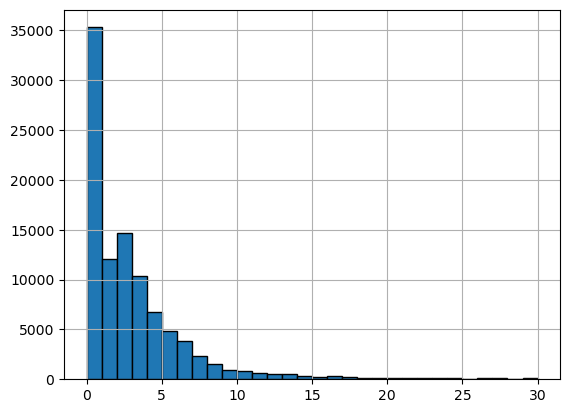

In [19]:
encdf2['lengthStay'].hist(bins=30, edgecolor='black')

####  The vairation here could be explained by service line. We can see from the historgram below with the length of stay by service line that ortho is different.

In [20]:
print("Service Lines:" + str(encdf2['service_line'].unique()))
print(" Number of lines: " + str(len(encdf2['service_line'].unique())))

Service Lines:['Internal Med' 'OB Gyn' 'Ortho' 'General Surg']
 Number of lines: 4


array([[<AxesSubplot:title={'center':'General Surg'}>,
        <AxesSubplot:title={'center':'Internal Med'}>],
       [<AxesSubplot:title={'center':'OB Gyn'}>,
        <AxesSubplot:title={'center':'Ortho'}>]], dtype=object)

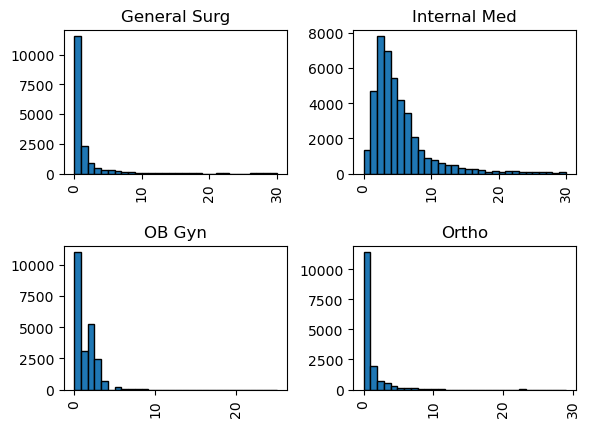

In [21]:
encdf2.hist(column=['lengthStay'], by=["service_line"], bins=30, edgecolor='black')

<p> By service line, it appears that internal medicne has a different peak and spread in their distribution of length of stay. Let's stack these distributions in one graph for another visual. </p>

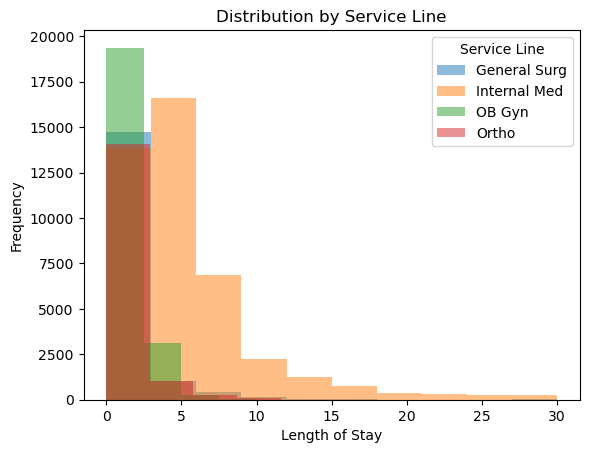

In [22]:
import matplotlib.pyplot as plt

#define points values by group
A = encdf2.loc[encdf2['service_line'] == 'General Surg', 'lengthStay']
B = encdf2.loc[encdf2['service_line'] == 'Internal Med', 'lengthStay']
C = encdf2.loc[encdf2['service_line'] == 'OB Gyn', 'lengthStay']
D = encdf2.loc[encdf2['service_line'] == 'Ortho', 'lengthStay']


#add three histograms to one plot
plt.hist(A, alpha=0.5, label='General Surg')
plt.hist(B, alpha=0.5, label='Internal Med')
plt.hist(C, alpha=0.5, label='OB Gyn')
plt.hist(D, alpha=0.5, label='Ortho')

#add plot title and axis labels
plt.title('Distribution by Service Line')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')

#add legend
plt.legend(title='Service Line')

#display plot
plt.show()


<p>Internal Medicine seems to have a shifted histogram compared to the service lines.</p>

## Merge with DRG table


Import the secod table with DRG and benchmarks

In [25]:
drg = pd.read_excel("hospital_encounter_data_10_24AC.xlsx", sheet_name=1)
print(drg.head())

   MS_DRG_NUM                                       MS-DRG Title  MDC  \
0           1  HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...  PRE   
1           2  HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...  PRE   
2           3  ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRIN...  PRE   
3           4  TRACHEOSTOMY WITH MV >96 HOURS OR PRINCIPAL DI...  PRE   
4           5  LIVER TRANSPLANT WITH MCC OR INTESTINAL TRANSP...  PRE   

  mdc_name  TYPE   weight geometric_mean_los arithmetic_mean_los  
0      NaN  SURG  28.1461               29.9                39.3  
1      NaN  SURG  13.4731               12.3                14.9  
2      NaN  SURG  20.2371               24.7                33.2  
3      NaN  SURG  13.7317               24.2                29.2  
4      NaN  SURG   11.407                 15                20.6  


In [26]:
drg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   MS_DRG_NUM           767 non-null    int64 
 1   MS-DRG Title         767 non-null    object
 2   MDC                  767 non-null    object
 3   mdc_name             742 non-null    object
 4   TYPE                 767 non-null    object
 5   weight               767 non-null    object
 6   geometric_mean_los   767 non-null    object
 7   arithmetic_mean_los  767 non-null    object
dtypes: int64(1), object(7)
memory usage: 48.1+ KB


Let's do a left join with our encounter data as the left table and right table is the DRG table. 

In [29]:
encdf3 = encdf2.merge(drg, left_on='drg', right_on='MS_DRG_NUM', how="left")

In [30]:
encdf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97435 entries, 0 to 97434
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   encounter_id         97435 non-null  object        
 1   admission_date       97435 non-null  datetime64[ns]
 2   origin               97435 non-null  object        
 3   service_line         97435 non-null  object        
 4   loc                  94512 non-null  object        
 5   drg                  90615 non-null  float64       
 6   discharge_date       97435 non-null  datetime64[ns]
 7   patient_zipcode      97435 non-null  int64         
 8   lengthStayPO         97435 non-null  int64         
 9   lengthStay           97435 non-null  int64         
 10  monthAdm             97435 non-null  int64         
 11  yearAdm              97435 non-null  int64         
 12  monthDis             97435 non-null  int64         
 13  yearDis              97435 non-

##### !!! important note: Dropped 6820 rows due to null values. Total number of rows: 97436-6820=90614

# Summary table by service line with day cases

In [33]:
encdf3.groupby("service_line").agg({"lengthStay": ["mean","median","std"],"encounter_id": "size"})

lengthStay                  encounter_id
                   mean median       std         size
service_line                                         
General Surg   0.863548    0.0  2.208031        16438
Internal Med   4.846789    4.0  4.482390        42719
OB Gyn         1.120219    1.0  1.341367        22800
Ortho          0.638196    0.0  1.543701        15478

# Summary table by service line without day cases

In [38]:
encdf_noday = encdf3[encdf3["lengthStay"] != 0]
print("number of day cases: "  + str(sum(encdf3["lengthStay"] == 0)) )
print("total number of encounters: " + str(len(encdf3)))
print(35300/97435*100)

number of day cases: 35300
total number of encounters: 97435
36.22928105916765


In [39]:
encdf_noday.groupby("service_line").agg({"lengthStay": ["mean","median","std"],"encounter_id": "size"})

lengthStay                  encounter_id
                   mean median       std         size
service_line                                         
General Surg   2.888685    2.0  3.234196         4914
Internal Med   5.005923    4.0  4.467088        41361
OB Gyn         2.165409    2.0  1.102139        11795
Ortho          2.430012    2.0  2.172571         4065

# Compare Internal Medicine and General Surgery

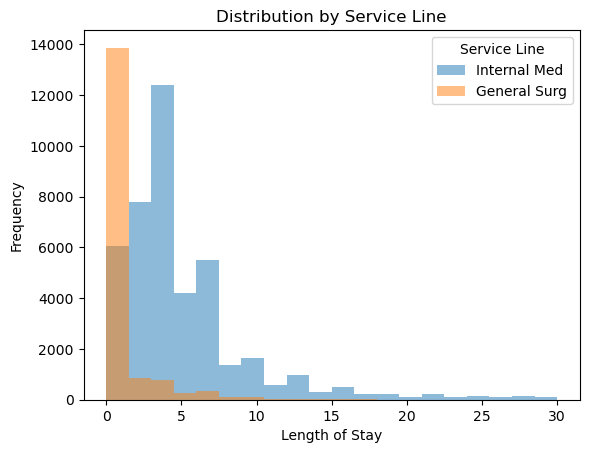

In [40]:
import matplotlib.pyplot as plt

#define points values by group
A = encdf3.loc[encdf2['service_line'] == 'General Surg', 'lengthStay']
B = encdf3.loc[encdf2['service_line'] == 'Internal Med', 'lengthStay']

#add three histograms to one plot
plt.hist(B, alpha=0.5, label='Internal Med', bins=20)
plt.hist(A, alpha=0.5, label='General Surg', bins=20)


#add plot title and axis labels
plt.title('Distribution by Service Line')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')

#add legend
plt.legend(title='Service Line')

#display plot
plt.show()

<p> Distribution looked different. Many more day cases for general surgery. The day cases are meaningful </p>

# Internal Medicine: Weight vs Expect LOS by DRG

In [46]:
import numpy as np
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

#encdf3["PropALOS_ABenchmark"] = encdf3['lengthStay'] / encdf3['arithmetic_mean_los']
encdf3["PropGLOS_GBenchmark"] = encdf3['lengthStay'] / encdf3['geometric_mean_los']

im = encdf3[encdf3['service_line'] == 'Internal Med']
imagg = im.groupby(["drg"]).agg({"lengthStay": ["mean","median",lambda x: g_mean(x)], 
                                                     "encounter_id": "size",
                                                     "PropALOS_ABenchmark":"mean",
                                                     "PropGLOS_GBenchmark":"median",
                                                     "weight":"max", 
                                                     "geometric_mean_los":"max",
                                                      "arithmetic_mean_los":"max",
                                                      "drg":"min"})


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


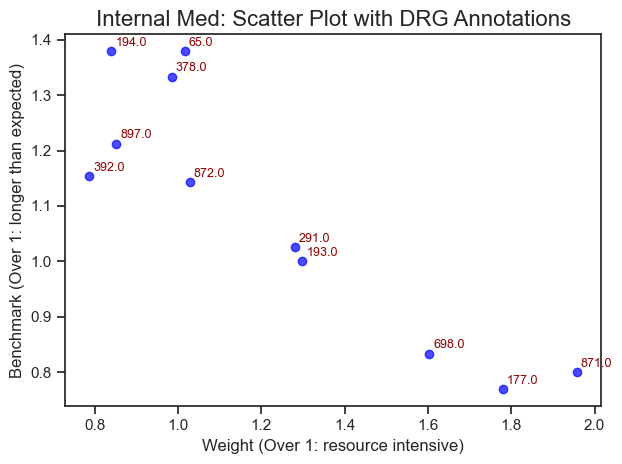

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure matplotlib and seaborn styles are set
sns.set(style="ticks")

# Extracting necessary values from 'imagg' DataFrame
# Assuming 'imagg' has MultiIndex due to the aggregation

# Create a scatter plot using 'geometric_mean_los' vs 'PropALOS_ABenchmark'
plt.scatter(imagg[('weight', 'max')], imagg[('PropGLOS_GBenchmark', 'median')],
            color='blue', alpha=0.7)

# Annotate each point with the 'drg' value
for i, row in imagg.iterrows():
    plt.text(row[('weight', 'max')] + 0.01,  # Adjust position of text
             row[('PropGLOS_GBenchmark', 'median')] + 0.01,  # Adjust position of text  # Annotation text (drg value)
             row['drg','min'],
             fontsize=9,  # Text size
             color='darkred')

# Add labels and title
plt.title('Internal Med: Scatter Plot with DRG Annotations', fontsize=16)
plt.xlabel('Weight (Over 1: resource intensive)', fontsize=12)
plt.ylabel('Benchmark (Over 1: longer than expected)', fontsize=12)

# Show the plot
plt.tight_layout()  # Make sure everything fits without overlapping
plt.show()

# General Surgery: Weight vs Expect LOS by DRG

In [50]:
import numpy as np
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

encdf3["PropALOS_ABenchmark"] = encdf3['lengthStay'] / encdf3['arithmetic_mean_los']
encdf3["PropGLOS_GBenchmark"] = encdf3['lengthStay'] / encdf3['geometric_mean_los']

gs = encdf3[encdf3['service_line'] == 'General Surg']
print(len(gs))
gsagg = gs.groupby(["drg"]).agg({"lengthStay": ["mean","median",lambda x: g_mean(x)], 
                                                     "encounter_id": "size",
                                                     "PropALOS_ABenchmark":"mean",
                                                     "PropGLOS_GBenchmark":"mean",
                                                     "weight":"max", 
                                                     "geometric_mean_los":"max",
                                                      "arithmetic_mean_los":"max",
                                                      "drg":"min"}) 


16438


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


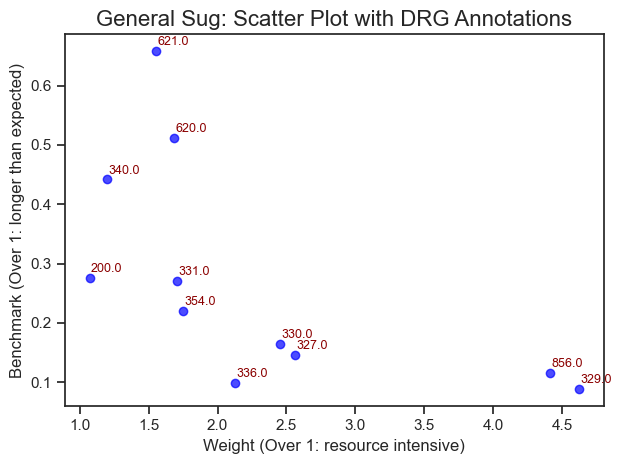

In [480]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure matplotlib and seaborn styles are set
sns.set(style="ticks")

# Extracting necessary values from 'imagg' DataFrame
# Assuming 'imagg' has MultiIndex due to the aggregation

# Create a scatter plot using 'geometric_mean_los' vs 'PropALOS_ABenchmark'
plt.scatter(gsagg[('weight', 'max')], gsagg[('PropGLOS_GBenchmark', 'mean')],
            color='blue', alpha=0.7)

# Annotate each point with the 'drg' value
for i, row in gsagg.iterrows():
    plt.text(row[('weight', 'max')] + 0.01,  # Adjust position of text
             row[('PropGLOS_GBenchmark', 'mean')] + 0.01,  # Adjust position of text  # Annotation text (drg value)
             row['drg','min'],
             fontsize=9,  # Text size
             color='darkred')

# Add labels and title
plt.title('General Sug: Scatter Plot with DRG Annotations', fontsize=16)
plt.xlabel('Weight (Over 1: resource intensive)', fontsize=12)
plt.ylabel('Benchmark (Over 1: longer than expected)', fontsize=12)

# Show the plot
plt.tight_layout()  # Make sure everything fits without overlapping
plt.show()

# Daily admission rate by service line

In [53]:
daily = encdf3.groupby(["admission_date","service_line"]).agg({"encounter_id": "size"})

In [54]:
daily.groupby(["service_line"]).agg({"encounter_id": "mean"})

,encounter_id
service_line,
General Surg,22.958101
Internal Med,59.663408
OB Gyn,31.843575
Ortho,29.996124


# Why has General Surgery been able to reduce its resource utilization, and what factors are driving this trend?

In [490]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2664 entries, (Timestamp('2022-01-01 00:00:00'), 'General Surg') to (Timestamp('2023-12-31 00:00:00'), 'OB Gyn')
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   encounter_id  2664 non-null   int64
dtypes: int64(1)
memory usage: 34.4+ KB


In [31]:
daily = encdf3.groupby(["admission_date","service_line"]).agg({"encounter_id": "size"})